In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.util.functions as func
import pandas as pd
import glob
import scipy
from scipy.interpolate import interp1d
import csv
import os
from sipm.analysis.SipmCalibration import SipmCalibration
import yaml

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [50]:
!pwd


/home/nwoofter/sipm-analysis


## Example waveforms

In [51]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-07-12/*/'
glob.glob(data_dir)

['/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-07-12/2023-07-12_volt_88_light_laser_config_1_cond_ln_intensity_1070/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-07-12/2023-07-12_volt_94_light_laser_config_1_cond_ln_intensity_1070/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-07-12/2023-07-12_volt_90_light_laser_config_1_cond_ln_intensity_1070/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-07-12/2023-07-12_volt_60_light_laser_config_1_cond_ln_long_intensity_1070/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-07-12/2023-07-12_volt_92_light_laser_config_1_cond_ln_intensity_1070/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-07-12/2023-07-12_volt_96_light_laser_config_1_cond_ln_intensity_1070/']

/scratch/gpfs/GALBIATI/data/sipm//hamamatsu_test/2023-07-12/2023-07-12_volt_96_light_laser_config_1_cond_ln_intensity_1070/1/wave0.dat
20812 events


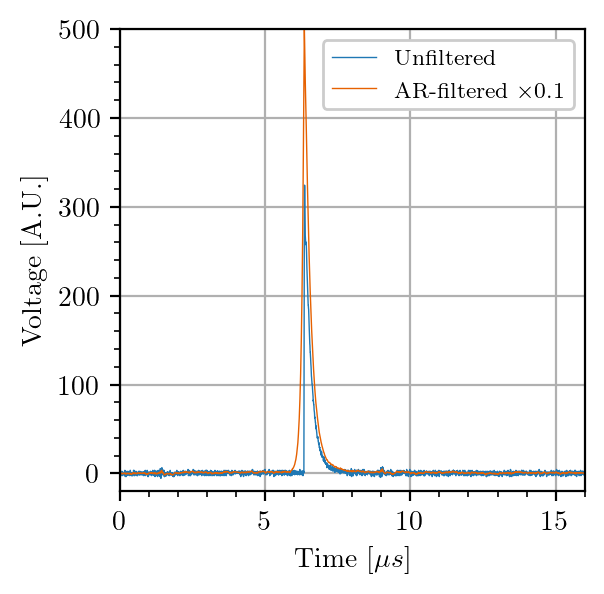

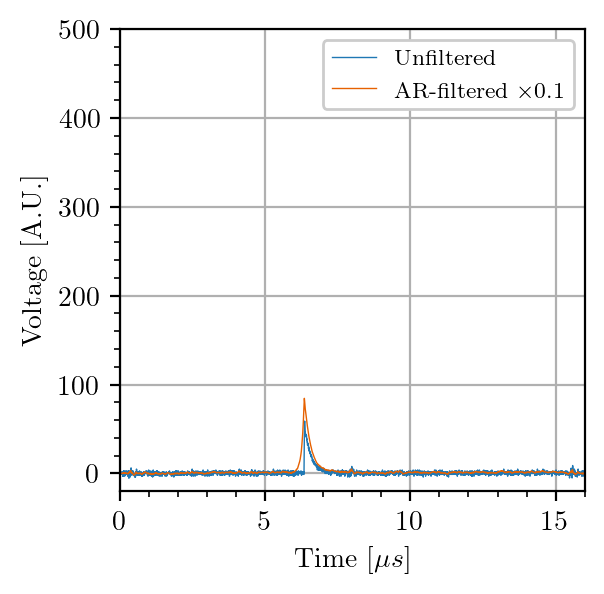

Error in callback <function flush_figures at 0x14feed057280> (for post_execute):


KeyboardInterrupt: 

In [6]:
import sipm.recon.WaveformDataset as wfd
ch = 0
evid = np.arange(5, 10)
dset = wfd.WaveformDataset(path='/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-07-12/2023-07-12_volt_96_light_laser_config_1_cond_ln_intensity_1070/1/', pol=-1, channels=range(4))
wfs, arwfs = dset.ch[ch].get_waveforms(ev=evid, ar_filter=True)

for i, wf in enumerate(wfs):
    plt.figure(i, figsize=(3, 3))
    plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
    plt.plot(dset.ch[ch].time, arwfs[i]*0.1,
             label=r'AR-filtered $\times0.1$', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0, 16)
    plt.ylim(-20, 500)

# Load pre-processed h5 files
These files should be processed by `exe/laser_pulse.py` script.

In [37]:
# data folder
path = "/scratch/gpfs/nwoofter/results/"
data = {}
intensity = [1070]
channels = [0, 1, 2, 3]
voltages = [88, 90, 92, 94, 96]
for intn in intensity:
    data[intn] = {}
    for ch in channels:
        data[intn][ch] = {}
        for volt in voltages:
            data[intn][ch][volt] = []
            files = glob.glob(f"{path}2023-07-12/*volt_{volt}*intensity_{intn}*[!_wf].h5")
            print(files)
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data[intn][ch][volt].append(df)
            data[intn][ch][volt] = pd.concat(
                data[intn][ch][volt], ignore_index=True)
#print('keys: ', list(data[1020][0][88].keys()))

['/scratch/gpfs/nwoofter/results/2023-07-12/2023-07-12_volt_88_light_laser_cond_ln_intensity_1070_config_1_intensity_1070_run4_laser_pulse.h5', '/scratch/gpfs/nwoofter/results/2023-07-12/2023-07-12_volt_88_light_laser_cond_ln_intensity_1070_config_1_intensity_1070_run2_laser_pulse.h5', '/scratch/gpfs/nwoofter/results/2023-07-12/2023-07-12_volt_88_light_laser_cond_ln_intensity_1070_config_1_intensity_1070_run0_laser_pulse.h5', '/scratch/gpfs/nwoofter/results/2023-07-12/2023-07-12_volt_88_light_laser_cond_ln_intensity_1070_config_1_intensity_1070_run1_laser_pulse.h5', '/scratch/gpfs/nwoofter/results/2023-07-12/2023-07-12_volt_88_light_laser_cond_ln_intensity_1070_config_1_intensity_1070_run3_laser_pulse.h5']
['/scratch/gpfs/nwoofter/results/2023-07-12/2023-07-12_volt_90_light_laser_cond_ln_intensity_1070_config_1_intensity_1070_run2_laser_pulse.h5', '/scratch/gpfs/nwoofter/results/2023-07-12/2023-07-12_volt_90_light_laser_cond_ln_intensity_1070_config_1_intensity_1070_run1_laser_pulse.h5

In [ ]:
intn = 1070
ch = 0
volt = 92
data[intn][ch][volt]

,baseline_mean,baseline_rms,amplitude_trig,peakpos_trig,integral_0p75us
0,3838.312628,1.632606,580.437676,1588,2141.587713
1,3837.778157,1.635965,548.640766,1589,2048.296928
2,3838.870990,1.562927,1804.181224,1586,6695.584983
3,3838.845734,1.609514,1643.254951,1593,6529.609556
4,3838.317406,1.498897,600.329657,1592,2214.529010
...,...,...,...,...,...
99995,3838.166553,1.579597,548.772834,1586,2015.810922
99996,3839.063481,1.653437,2276.808865,1589,8659.505802
99997,3838.727645,1.586274,2948.184526,1588,10881.346075
99998,3838.647099,1.578125,553.077757,1594,2128.478498


In [ ]:
intn = 1070
ch = 0
volt = 96


plt.hist(data[intn][ch][volt]['integral_0p75us'], bins=500, histtype='step')

plt.minorticks_on()
plt.grid()
#plt.xlim(0, 10000)
#plt.yscale('log')

In [ ]:
from scipy.stats import gaussian_kde

intn = 1070
ch = 0
volt = 96

amp = data[intn][ch][volt]['amplitude_trig']
integ = data[intn][ch][volt]['integral_0p75us']


xy = np.vstack([amp, integ])
z = gaussian_kde(xy)(xy)

plt.scatter(amp, integ, c=z, s=0.25)
plt.xlabel('Amplitude')
plt.ylabel('Integral')
plt.title('Channel 4')
plt.minorticks_on()
plt.grid()

In [ ]:
intn = 1070
ch = 0
volt = 88


plt.hist(data[intn][ch][volt]['baseline_mean'], bins=500, histtype='step')
plt.minorticks_on()
plt.title('Baseline Mean Channel 1 (log-scale)')
plt.yscale('log')
plt.grid()

In [ ]:
intn = 1070
ch = 1
volt = 88


plt.hist(data[intn][ch][volt]['baseline_rms'], bins=500, histtype='step')
plt.minorticks_on()
plt.title('Baseline RMS Channel 2 (log-scale)')
plt.yscale('log')
#plt.xlim(2, 3)
plt.grid()

In [ ]:
intn = 1070
ch = 0
volt = 88

integral = data[intn][ch][volt]['integral_0p75us']
amp_trig = data[intn][ch][volt]['amplitude_trig']

i = 0
pk2 = []
for x in amp_trig:
    if x > 300 and x < 500:
        pk2.append(integral[i])
    i += 1
    

plt.hist(integral, bins=300, histtype='step')
plt.minorticks_on()
plt.grid()
plt.yscale

In [ ]:
intn = 1070
ch = 1
volt = 88


plt.hist(data[intn][ch][volt]['amplitude_trig'], bins=500, histtype='step')
plt.minorticks_on()
plt.grid()
plt.xlim(100, 500)
plt.yscale('log')

In [ ]:
intn = 1020
ch = 1
volt = 90

integral = data[intn][ch][volt]['integral_5p00us']
amp_trig = data[intn][ch][volt]['amplitude_trig']

i = 0
pk2 = []
for x in amp_trig:
    if x > 160 and x < 360:
        pk2.append(integral[i])
    i += 1

plt.hist(integral, bins=100, histtype='step')
plt.minorticks_on()
plt.grid()

In [3]:
intensities = [1070]
channels = [0, 1, 2, 3]
voltages = [88, 90, 92, 94, 96]
metadata_dict = {}
for intn in intensities:
    metadata_dict[intn] = {}
    for ch in channels:
        metadata_dict[intn][ch] = {}
        for volt in voltages:
            metadata_dict[intn][ch][volt] = {'metadata':{
                'date':'2023-07-12',
                'volt': volt,
                'intn': intn,
                'light': 'laser',
                'coinc': 'laser',
                'cond': 'calibration',
                'run': '*',
                'ch': ch
            }}

In [4]:
calibration = SipmCalibration(
    intensities,
    voltages=voltages,
    channels=channels,
    directory='/scratch/gpfs/nwoofter/results/',
    metadata_dict=metadata_dict,
    script='laser_pulse',
    merge=True,
    verbose=True
)
calibration.load_files()

2023-07-12 88V 1070 laser coinc=laser cond=calibration run* ch0 script=laser_pulse.py - 0 files 0 events


AttributeError: 'list' object has no attribute 'keys'

In [ ]:
calibration.charge_analysis()

In [ ]:
# Make plots for all datasets
# Charge histograms
fig, axs = plt.subplots(8, 5, sharex=True, sharey=True)
fig.set_size_inches(15, 24)
for i, intn in enumerate(intensities):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            for pe in calibration.charge_hist[intn][ch][volt].keys():
                axs[i*4+j, k].stairs(calibration.charge_hist[intn][ch][volt][pe]['hist'],
                                     calibration.charge_hist[intn][ch][volt][pe]['bins'], label=f'{pe}PE', color=f'C{pe}')
                fit_min = calibration.charge_fits[intn][ch][volt][pe]['min_bin']
                fit_max = calibration.charge_fits[intn][ch][volt][pe]['max_bin']
                axs[i*4+j, k].plot(calibration.charge_hist[intn][ch][volt][pe]['bins'][fit_min:fit_max], func.gauss_normalized(
                    calibration.charge_hist[intn][ch][volt][pe]['bins'][fit_min:fit_max], *calibration.charge_fits[intn][ch][volt][pe]['par']), f'k--', linewidth=1)
            axs[i*4+j, k].legend(loc='upper right')
            axs[i*4+j, k].set_ylim(1, 5e3)
            xmin = calibration.charge_hist[intn][ch][volt][list(
                calibration.charge_hist[intn][ch][volt].keys())[-1]]['bins'][0]
            xmax = calibration.charge_hist[intn][ch][volt][list(
                calibration.charge_hist[intn][ch][volt].keys())[-1]]['bins'][-1]
            axs[i*4+j, k].set_xlim(xmin, xmax)
            axs[i*4+j, k].set_yscale('log')
            axs[i*4+j, k].minorticks_on()
            axs[i*4+j, k].grid()
            axs[i*4+j,
                k].set_title(f'{intn[0].upper()}{intn[1:]} Ch{ch} {volt}V')
fig.supxlabel(r'Charge integral [A.U.]', y=0.07)
fig.supylabel(r'Count', x=0.07)